<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Maize_leaf_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import neccessary packages

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,RMSprop,Adam, Adadelta
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from subprocess import check_output
print(check_output(["ls", "../input/corndieases/corn disease"]).decode("utf8"))


 healthy
Cercospora leaf spot Gray leaf spot
Common rust
Northern Leaf Blight



In [ ]:
import os
print(os.listdir("../input/corndieases/corn disease"))

['Northern Leaf Blight', 'Common rust', ' healthy', 'Cercospora leaf spot Gray leaf spot']


In [ ]:
n = 224

In [ ]:
EPOCHS = 50

INIT_LR = 1e-4
BS = 64
default_image_size = tuple((n, n))
image_size = 0
directory_root = '../input/corndieases/'
width=n
height=n
depth=3

Function to convert images to array

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Northern Leaf Blight ...
[INFO] Processing Common rust ...
[INFO] Processing  healthy ...
[INFO] Processing Cercospora leaf spot Gray leaf spot ...
[INFO] Image loading completed


Get Size of Processed Image

In [ ]:
image_size = len(image_list)
print(image_size)

4365


Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [ ]:
print(label_binarizer.classes_)

[' healthy' 'Cercospora leaf spot Gray leaf spot' 'Common rust'
 'Northern Leaf Blight']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float32) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


# Taking 200 images seperate for final testing

In [ ]:
x_test_final = x_test[-200:]
y_test_final = y_test[-200:]

x_test = x_test[:-200]
y_test = y_test[:-200]

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
from keras import layers
from keras.models import Model

from keras.applications import VGG16

In [ ]:
def return_model():
    pretrained_model = VGG16(include_top=False,weights="imagenet", input_shape=(n, n,3))
    
    new_model = Sequential()
    new_model.add(pretrained_model)
    
    new_model.add(Flatten())
    new_model.add(Dense(256,activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(4,activation='softmax'))

    
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    new_model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    return new_model

Model Summary

In [ ]:
model = return_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 21,138,500
Non-trainable params: 0
_________________________________________________________________


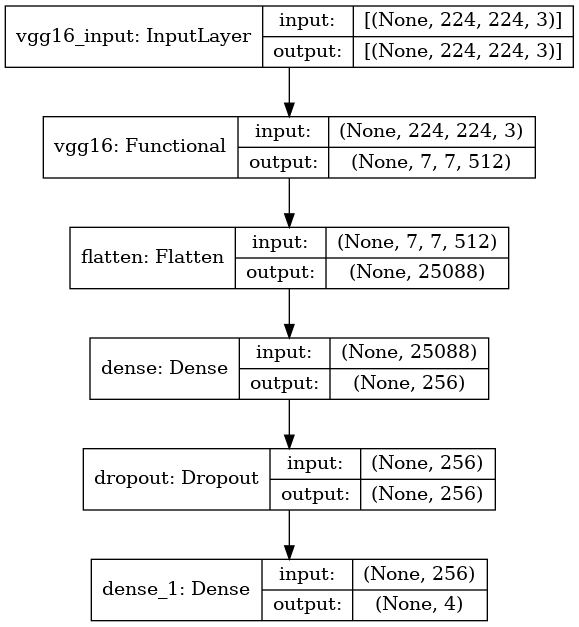

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
#model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


# Adding Callback

In [ ]:
from keras import callbacks
file_path = "weights_best_.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list 
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
54/54 [==============================] - 69s 1s/step - loss: 0.8428 - accuracy: 0.6275 - val_loss: 0.1969 - val_accuracy: 0.9212
Epoch 2/50
54/54 [==============================] - 47s 871ms/step - loss: 0.2299 - accuracy: 0.9126 - val_loss: 0.2198 - val_accuracy: 0.9034
Epoch 3/50
54/54 [==============================] - 46s 858ms/step - loss: 0.1760 - accuracy: 0.9316 - val_loss: 0.0973 - val_accuracy: 0.9658
Epoch 4/50
54/54 [==============================] - 46s 846ms/step - loss: 0.1260 - accuracy: 0.9538 - val_loss: 0.1216 - val_accuracy: 0.9599
Epoch 5/50
54/54 [==============================] - 46s 848ms/step - loss: 0.1103 - accuracy: 0.9595 - val_loss: 0.0947 - val_accuracy: 0.9584
Epoch 6/50
54/54 [==============================] - 47s 865ms/step - loss: 0.1034 - accuracy: 0.9659 - val_loss: 0.0860 - val_accuracy: 0.9733
Epoch 7/50
54/54 [==============================] - 46s 849ms/step - loss: 0.0913 - accuracy: 0.9636 - val_loss: 0.0828 - val_accuracy: 0.9747
Ep

Plot the train and val curve

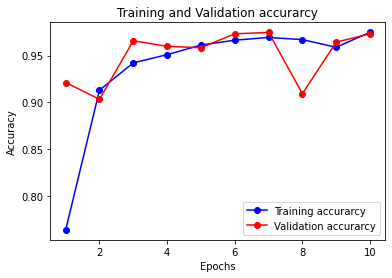

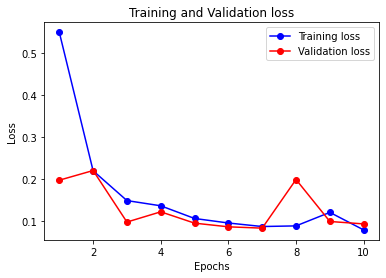

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

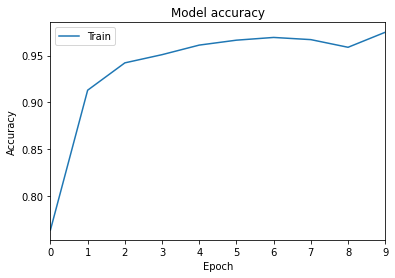

In [ ]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.margins(x=0)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

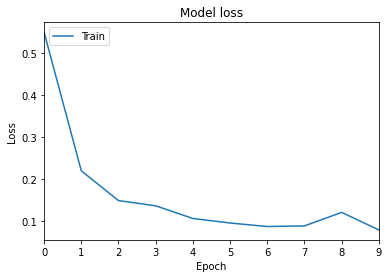

In [ ]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.margins(x=0)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



Model Accuracy

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
7/7 [==============================] - 1s 196ms/step - loss: 0.1633 - accuracy: 0.9550
Test Accuracy: 95.49999833106995


Save model using Pickle

In [ ]:
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test_final)

#getting labels
y_pred_labels = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test_final,axis = 1)

In [ ]:
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Change the class name as per your desire

In [ ]:
label_binarizer.classes_

array([' healthy', 'Cercospora leaf spot Gray leaf spot', 'Common rust',
       'Northern Leaf Blight'], dtype='<U35')

1. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
2. Corn_(maize)___Common_rust_
3. Corn_(maize)___healthy
4. Corn_(maize)___Northern_Leaf_Blight


# Change name in the label

In [ ]:
label = ['Corn_(maize)___healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_','Corn_(maize)___Northern_Leaf_Blight']
label = np.array(label)

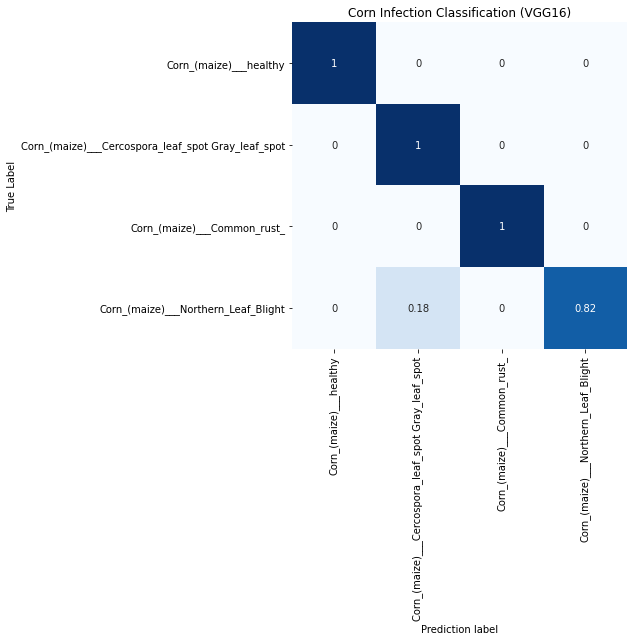

In [ ]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from itertools import cycle

#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label,
                     columns = label
                    )


plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Blues',cbar=False)
plt.title('Corn Infection Classification (VGG16)')
plt.ylabel('True Label')
plt.xlabel('Prediction label')
plt.show()

# ROC Curve


In [ ]:
new_label = label
new_class = 4

In [ ]:
label.shape

(4,)

In [ ]:
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

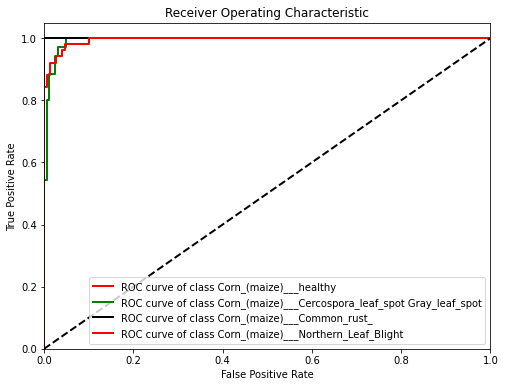

In [ ]:
plt.rcParams["figure.figsize"] = [8,6]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test_final[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['red', 'green','black'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(label[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


In [ ]:
y_pred_probs = model.predict(x_test_final)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# reduce to 1d array
yhat_probs = y_pred_probs[:,0]
yhat_classes = y_pred_classes

y_test_final = np.argmax(y_test_final, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_final, yhat_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.80      1.00      0.89        35
           2       1.00      1.00      1.00        55
           3       1.00      0.82      0.90        51

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200

